In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn import svm
from sklearn.model_selection import train_test_split as tts
import random
from sklearn import metrics 

In [3]:
#normalising the data set
df = pd.read_csv('data.csv')
normalized_df=(df-df.min())/(df.max()-df.min())
data = np.array(normalized_df)
X = data[:, 1:-1]
y = data[:, -1]
m,n = X.shape
print(type(y[0]))
print(y.shape)
print(X.shape)

<class 'numpy.float64'>
(506,)
(506, 12)


In [4]:
#kernel functions used
def kernel(kernel_type, A1, A2, gamma, degree):
    if kernel_type == 'linear':
        return np.dot(A1, A2.T)
    if kernel_type == 'rbf':
        K = np.zeros((A1.shape[0], A2.shape[0]))
        for i, a1 in enumerate(A1):
            for j, a2 in enumerate(A2):
                K[i, j] = np.exp(-gamma * np.linalg.norm(a1 - a2) ** 2)
        return K
    if kernel_type == 'poly':
        K = np.zeros((A1.shape[0], A2.shape[0]))
        for i, a1 in enumerate(A1):
            for j, a2 in enumerate(A2):
                K[i, j] = gamma*((a1@a2.T + 1) ** degree)
        return K
        
    

# Epsilon SVR

In [5]:
#formulating eps-SVR
def svr_cvxopt(X_train, y_train, X_test, C, eps, kernel_type, gamma, degree):
    X = X_train
    y = y_train
    m,n = X.shape


    y = y.reshape(-1,1) * 1
    print(y.shape)
    q1 = eps - y
    q2 = eps + y
    K = kernel(kernel_type, X, X, gamma, degree)
    p1 = np.hstack((K, K*-1))
    P = cvxopt_matrix(np.vstack((p1, p1*-1)))
    q = cvxopt_matrix(np.vstack((q1, q2)))
    G = cvxopt_matrix(np.vstack((np.eye(2*m)*-1, np.eye(2*m))))
    h = cvxopt_matrix(np.hstack((np.zeros(2*m), np.ones(2*m) * C)))
    A = cvxopt_matrix((np.hstack((np.ones(m), np.ones(m)*-1))).reshape(1,-1))
    # print(A.shape)
    b = cvxopt_matrix(np.zeros(1))

    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    # print(alphas)
    alphas1 = alphas[:m]
    alphas2 = alphas[m:2*m]
    b = np.array(sol['y'])
#     print(b)
#     W = ((alphas1 - alphas2).T @ X).reshape(-1, 1) ## W is a column vector
    y_pred = kernel(kernel_type, X, X_test, gamma, degree).T@(alphas1 - alphas2) + b
#     print(y_pred)
    return y_pred


In [6]:
# k-fold cross validation
# returns MSE for both cvxopt and sklearn on gthe given dataset
def cross_val(X, y, num_folds, C, eps, kernel_type, gamma, degree):
    y = y.reshape(-1,1) * 1
    m, n = X.shape
    batch_size = m//num_folds

    mse1 = 0
    mse2 = 0
    for i in range(1, num_folds+1):
        X_test = X[(i-1)*batch_size: i*batch_size, :]
        y_test = y[(i-1)*batch_size: i*batch_size:, ]
        if i == 1:
            X_train = X[i*batch_size : , :]
            y_train = y[i*batch_size :, :]
        else:
            X_train = X[: (i-1)*batch_size, :]
            np.vstack((X_train, X[i*batch_size : , :]))
            y_train = y[: (i-1)*batch_size, :]
            np.vstack((y_train, y[i*batch_size : , :]))
        reg = svm.SVR(kernel = kernel_type, gamma = gamma, degree = degree,  C = C, epsilon = eps).fit(X_train, y_train.ravel()) 
        y_sk = reg.predict(X_test)
        
        y_pred = svr_cvxopt(X_train, y_train, X_test, C, eps, kernel_type, gamma, degree)
        y_pred = y_pred[:, 0]
        y_test = y_test[:, 0]
#         print(y_pred.shape)
#         print(y_test.shape)
#         print(y_sk.shape)
#         print(np.max(y_pred-y_test))
#         print(np.min(y_pred-y_test))
        mse1 += (np.linalg.norm(y_pred - y_test) ** 2)/y_test.shape[0]
        mse2 += (np.linalg.norm(y_sk - y_test) ** 2)/y_test.shape[0]

#         score1 += metrics.r2_score(y_test,y_pred)
#         score2 += metrics.r2_score(y_test,y_sk)

    mse1 = mse1/num_folds
    mse2 = mse2/num_folds
    return mse1, mse2
    

In [7]:
#k-fold cross validation , retuns the MSE for cvxopt implemantation
def cross_val_cvx(X, y, num_folds, C, eps, kernel_type, gamma, degree):
    y = y.reshape(-1,1) * 1
    m, n = X.shape
    batch_size = m//num_folds

    mse1 = 0
    for i in range(1, num_folds+1):
        X_test = X[(i-1)*batch_size: i*batch_size, :]
        y_test = y[(i-1)*batch_size: i*batch_size:, ]
        if i == 1:
            X_train = X[i*batch_size : , :]
            y_train = y[i*batch_size :, :]
        else:
            X_train = X[: (i-1)*batch_size, :]
            np.vstack((X_train, X[i*batch_size : , :]))
            y_train = y[: (i-1)*batch_size, :]
            np.vstack((y_train, y[i*batch_size : , :]))
        
        y_pred = svr_cvxopt(X_train, y_train, X_test, C, eps, kernel_type, gamma, degree)
        y_pred = y_pred[:, 0]
        y_test = y_test[:, 0]

        mse1 += (np.linalg.norm(y_pred - y_test) ** 2)/y_test.shape[0]
        
    mse1 = mse1/num_folds

    return mse1
    

In [8]:
#k-fold cross validation , retuns the MSE for sklearn implemantation
def cross_val_sk(X, y, num_folds, C, eps, kernel_type, gamma, degree):
    y = y.reshape(-1,1) * 1
    m, n = X.shape
    batch_size = m//num_folds

    mse = 0

    for i in range(1, num_folds+1):
        X_test = X[(i-1)*batch_size: i*batch_size, :]
        y_test = y[(i-1)*batch_size: i*batch_size:, ]
        if i == 1:
            X_train = X[i*batch_size : , :]
            y_train = y[i*batch_size :, :]
        else:
            X_train = X[: (i-1)*batch_size, :]
            np.vstack((X_train, X[i*batch_size : , :]))
            y_train = y[: (i-1)*batch_size, :]
            np.vstack((y_train, y[i*batch_size : , :]))
        reg = svm.SVR(kernel = kernel_type, gamma = gamma, degree = degree,  C = C, epsilon = eps).fit(X_train, y_train.ravel()) 
        y_sk = reg.predict(X_test)
        y_test = y_test[:, 0]
        mse += (np.linalg.norm(y_sk - y_test) ** 2)/y_test.shape[0]

    mse = mse/num_folds
    return mse
    

# Linear Kernel

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.1069e+01 -1.0438e+03  1e+03  4e-17  2e-13
 1:  2.5688e+01 -5.6501e+01  8e+01  1e-13  3e-13
 2: -1.7302e-01 -1.4048e+01  1e+01  9e-14  2e-13
 3: -5.3463e+00 -1.0498e+01  5e+00  6e-14  1e-13
 4: -7.5203e+00 -8.8308e+00  1e+00  7e-15  1e-13
 5: -8.0178e+00 -8.4297e+00  4e-01  1e-14  9e-14
 6: -8.1442e+00 -8.3217e+00  2e-01  4e-15  9e-14
 7: -8.2098e+00 -8.2669e+00  6e-02  1e-14  9e-14
 8: -8.2327e+00 -8.2454e+00  1e-02  4e-14  9e-14
 9: -8.2383e+00 -8.2404e+00  2e-03  4e-14  9e-14
10: -8.2393e+00 -8.2393e+00  2e-05  1e-14  1e-13
11: -8.2393e+00 -8.2393e+00  2e-07  1e-14  1e-13
Optimal solution found.
(101,)
0.005749803190830993
0.005780529207454496


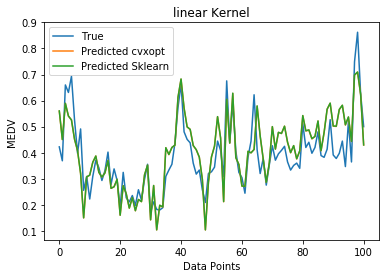

In [6]:
#plot of the predicted MEDV values vs the true values for the linear kernel
X_train = X[101: , :]
y_train = y[101: ]
X_test = X[:101, :]
y_test = y[:101]
reg = svm.SVR(kernel = 'linear', degree = 2, C = 1, epsilon = 0.1).fit(X_train, y_train.ravel()) 
y_sk = reg.predict(X_test)
# score1 = reg.score(X_test, y_test)
y_pred = svr_cvxopt(X_train, y_train, X_test, 1, 0.1, 'linear', 1, 2)
# print(y_pred)
# print(y_sk)
# print(y)
y_pred = y_pred[:, 0]
print(y_pred.shape)
print((np.linalg.norm(y_pred - y_test) ** 2)/y_test.shape[0])
print((np.linalg.norm(y_sk - y_test) ** 2)/y_test.shape[0])
# print(np.max(y_sk-y_test))

Xx = np.array(list(range(0, y_test.shape[0]))).reshape(y_test.shape[0], 1)
plt.plot(Xx, y_test, label ='True')
plt.plot(Xx, y_pred, label ='Predicted cvxopt')

plt.plot(Xx, y_sk, label ='Predicted Sklearn')
plt.xlabel('Data Points')
plt.ylabel('MEDV')
plt.legend()
plt.title('linear Kernel')
plt.show()

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.1069e+01 -1.0438e+03  1e+03  4e-17  2e-13
 1:  2.5688e+01 -5.6501e+01  8e+01  1e-13  3e-13
 2: -1.7302e-01 -1.4048e+01  1e+01  9e-14  2e-13
 3: -5.3463e+00 -1.0498e+01  5e+00  6e-14  1e-13
 4: -7.5203e+00 -8.8308e+00  1e+00  7e-15  1e-13
 5: -8.0178e+00 -8.4297e+00  4e-01  1e-14  9e-14
 6: -8.1442e+00 -8.3217e+00  2e-01  4e-15  9e-14
 7: -8.2098e+00 -8.2669e+00  6e-02  1e-14  9e-14
 8: -8.2327e+00 -8.2454e+00  1e-02  4e-14  9e-14
 9: -8.2383e+00 -8.2404e+00  2e-03  4e-14  9e-14
10: -8.2393e+00 -8.2393e+00  2e-05  1e-14  1e-13
11: -8.2393e+00 -8.2393e+00  2e-07  1e-14  1e-13
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  8.5706e+00 -2.2923e+02  2e+02  6e-15  3e-14
 1:  7.5788e+00 -1.0458e+01  2e+01  4e-15  3e-14
 2:  1.4652e+00 -1.6440e+00  3e+00  7e-15  2e-14
 3:  1.9632e-01 -8.4591e-01  1e+00  2e-15  1e-14
 4: -1.4027e-01 -5.4329e-01  4e-01  6e-15  6e-15
 5: -2.6542e-01 -4.4041e-01  

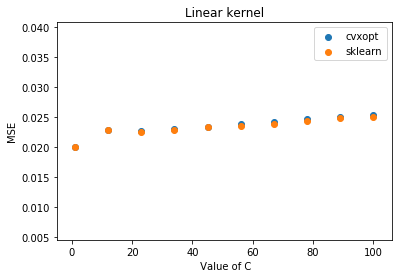

In [16]:
#plot of the MSE vs the hyperparamter C for linear kernel
C_values = np.linspace(1, 100, 10, endpoint=True)
mse_cvxopt = []
mse_sk = []
# mse_sklearn = []
for i in C_values:         
    mse1, mse2 = cross_val(X, y, 5, i, 0.1, 'linear', 1, 1)
    mse_cvxopt.append(mse1)
    mse_sk.append(mse2)

print(mse_cvxopt)
print(mse_sk)   
plt.scatter(C_values, mse_cvxopt, label ='cvxopt')
plt.scatter(C_values, mse_sk, label ='sklearn')

plt.xlabel(' Value of C')
plt.ylabel('MSE')
plt.legend()
plt.title('Linear kernel')
plt.show()
# plt.savefig('MEDV vs data.png')

(405, 1)
     pcost       dcost       gap    pres   dres
 0: -1.3713e+00 -1.0438e+03  1e+03  4e-14  2e-13
 1: -4.4494e+00 -8.4385e+01  8e+01  1e-14  3e-13
 2: -1.8921e+01 -3.5070e+01  2e+01  7e-14  3e-13
 3: -2.4805e+01 -2.9071e+01  4e+00  6e-14  3e-13
 4: -2.6122e+01 -2.7900e+01  2e+00  4e-14  3e-13
 5: -2.6692e+01 -2.7325e+01  6e-01  9e-14  2e-13
 6: -2.6928e+01 -2.7094e+01  2e-01  1e-13  3e-13
 7: -2.6989e+01 -2.7033e+01  4e-02  2e-13  3e-13
 8: -2.7005e+01 -2.7016e+01  1e-02  2e-13  2e-13
 9: -2.7010e+01 -2.7012e+01  2e-03  7e-14  3e-13
10: -2.7011e+01 -2.7011e+01  8e-05  1e-13  3e-13
11: -2.7011e+01 -2.7011e+01  1e-06  3e-14  3e-13
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  4.8053e-01 -2.2923e+02  2e+02  8e-15  3e-14
 1:  2.1459e-01 -1.5448e+01  2e+01  5e-14  4e-14
 2: -1.5138e+00 -4.5494e+00  3e+00  6e-14  4e-14
 3: -2.5190e+00 -3.3879e+00  9e-01  3e-14  3e-14
 4: -2.7897e+00 -3.1256e+00  3e-01  2e-14  3e-14
 5: -2.8885e+00 -3.0249e+00  

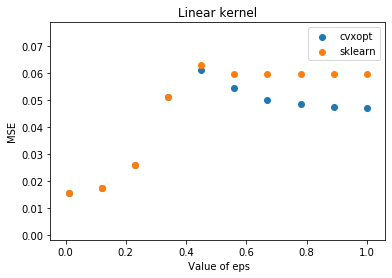

In [17]:
#plot of the MSE vs the eps for linear kernel
x_values = np.linspace(0.01, 1, 10, endpoint=True)
mse_cvxopt = []
mse_sk = []
# mse_sklearn = []
for i in x_values:         
    mse1, mse2 = cross_val(X, y, 5, 1, i, 'linear', 1, 1)
    mse_cvxopt.append(mse1)
    mse_sk.append(mse2)

print(mse_cvxopt)
print(mse_sk)   
plt.scatter(x_values, mse_cvxopt, label ='cvxopt')
plt.scatter(x_values, mse_sk, label ='sklearn')

plt.xlabel(' Value of eps')
plt.ylabel('MSE')
plt.legend()
plt.title('Linear kernel')
plt.show()
# plt.savefig('MEDV vs data.png')

# RBF Kernel

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.2903e+01 -1.0290e+03  1e+03  1e-13  2e-14
 1:  2.8894e+01 -4.7823e+01  8e+01  2e-13  3e-14
 2:  4.9020e+00 -8.6625e+00  1e+01  9e-14  2e-14
 3: -1.3209e+00 -4.5715e+00  3e+00  4e-15  8e-15
 4: -2.5105e+00 -3.5804e+00  1e+00  1e-14  4e-15
 5: -2.9744e+00 -3.1982e+00  2e-01  2e-14  3e-15
 6: -3.0743e+00 -3.1005e+00  3e-02  2e-14  3e-15
 7: -3.0864e+00 -3.0886e+00  2e-03  4e-15  3e-15
 8: -3.0875e+00 -3.0875e+00  5e-05  4e-15  3e-15
 9: -3.0875e+00 -3.0875e+00  1e-06  5e-15  3e-15
Optimal solution found.
(101,)
0.004568310071487877
0.004562841565504412


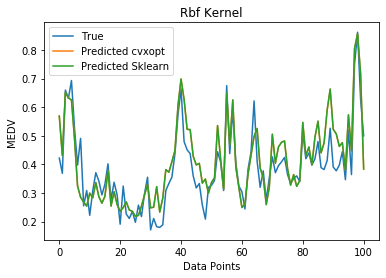

In [12]:
#plot of the predicted MEDV values vs the true values for the rbf kernel
X_train = X[101: , :]
y_train = y[101: ]
X_test = X[:101, :]
y_test = y[:101]
reg = svm.SVR(kernel = 'rbf', gamma = 1, C = 1, epsilon = 0.1).fit(X_train, y_train.ravel()) 
y_sk = reg.predict(X_test)
# score1 = reg.score(X_test, y_test)
y_pred = svr_cvxopt(X_train, y_train, X_test, 1, 0.1, 'rbf', 1, 2)
# print(y_pred)
# print(y_sk)
# print(y)
y_pred = y_pred[:, 0]
print(y_pred.shape)
print((np.linalg.norm(y_pred - y_test) ** 2)/y_test.shape[0])
print((np.linalg.norm(y_sk - y_test) ** 2)/y_test.shape[0])
# print(np.max(y_sk-y_test))

Xx = np.array(list(range(0, y_test.shape[0]))).reshape(y_test.shape[0], 1)
plt.plot(Xx, y_test, label ='True')
plt.plot(Xx, y_pred, label ='Predicted cvxopt')

plt.plot(Xx, y_sk, label ='Predicted Sklearn')
plt.xlabel('Data Points')
plt.ylabel('MEDV')
plt.legend()
plt.title('Rbf Kernel')
plt.show()

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.2903e+01 -1.0290e+03  1e+03  1e-13  2e-14
 1:  2.8894e+01 -4.7823e+01  8e+01  2e-13  3e-14
 2:  4.9020e+00 -8.6625e+00  1e+01  9e-14  2e-14
 3: -1.3209e+00 -4.5715e+00  3e+00  4e-15  8e-15
 4: -2.5105e+00 -3.5804e+00  1e+00  1e-14  4e-15
 5: -2.9744e+00 -3.1982e+00  2e-01  2e-14  3e-15
 6: -3.0743e+00 -3.1005e+00  3e-02  2e-14  3e-15
 7: -3.0864e+00 -3.0886e+00  2e-03  4e-15  3e-15
 8: -3.0875e+00 -3.0875e+00  5e-05  4e-15  3e-15
 9: -3.0875e+00 -3.0875e+00  1e-06  5e-15  3e-15
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  8.6528e+00 -2.2582e+02  2e+02  4e-14  8e-15
 1:  7.7112e+00 -9.9929e+00  2e+01  4e-14  1e-14
 2:  1.3801e+00 -1.2561e+00  3e+00  1e-14  7e-15
 3: -6.1986e-02 -4.5410e-01  4e-01  1e-14  2e-15
 4: -1.9257e-01 -3.0325e-01  1e-01  3e-15  8e-16
 5: -2.2428e-01 -2.8282e-01  6e-02  6e-16  7e-16
 6: -2.4292e-01 -2.6016e-01  2e-02  8e-16  6e-16
 7: -2.4957e-01 -2.5240e-01  

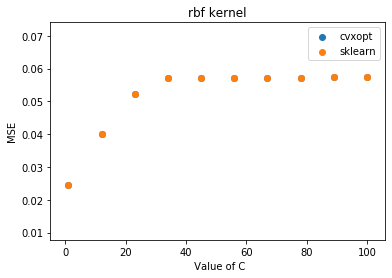

In [20]:
#plot of the MSE vs the hyperparamter C for rbf kernel
x_values = np.linspace(1, 100, 10, endpoint=True)
mse_cvxopt = []
mse_sk = []
# mse_sklearn = []
for i in x_values:         
    mse1, mse2 = cross_val(X, y, 5, i, 0.1, 'rbf', 1, 1)
    mse_cvxopt.append(mse1)
    mse_sk.append(mse2)

print(mse_cvxopt)
print(mse_sk)   
plt.scatter(x_values, mse_cvxopt, label ='cvxopt')
plt.scatter(x_values, mse_sk, label ='sklearn')

plt.xlabel(' Value of C')
plt.ylabel('MSE')
plt.legend()
plt.title('rbf kernel')
plt.show()
# plt.savefig('MEDV vs data.png')

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.0011e+01 -1.0632e+03  1e+03  1e-14  6e-14
 1:  2.4891e+01 -5.9979e+01  8e+01  6e-14  8e-14
 2: -3.8585e-02 -1.3976e+01  1e+01  4e-14  6e-14
 3: -5.7212e+00 -1.0684e+01  5e+00  1e-14  3e-14
 4: -7.5642e+00 -9.3356e+00  2e+00  8e-14  2e-14
 5: -8.2274e+00 -8.8217e+00  6e-01  3e-14  2e-14
 6: -8.4503e+00 -8.6342e+00  2e-01  4e-14  2e-14
 7: -8.5335e+00 -8.5659e+00  3e-02  4e-14  2e-14
 8: -8.5486e+00 -8.5499e+00  1e-03  1e-14  2e-14
 9: -8.5492e+00 -8.5492e+00  1e-05  5e-14  2e-14
10: -8.5492e+00 -8.5492e+00  1e-07  2e-14  2e-14
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  8.1520e+00 -2.4002e+02  2e+02  3e-15  1e-14
 1:  7.0256e+00 -1.1538e+01  2e+01  2e-14  2e-14
 2:  1.0019e+00 -2.5563e+00  4e+00  2e-14  1e-14
 3: -1.3453e-01 -1.5789e+00  1e+00  9e-15  5e-15
 4: -4.3233e-01 -1.3318e+00  9e-01  9e-15  4e-15
 5: -6.9023e-01 -1.0911e+00  4e-01  2e-15  3e-15
 6: -8.7386e-01 -9.3032e-01  

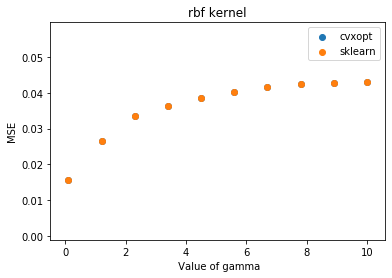

In [22]:
#plot of the MSE vs the hyperparamter gamma for rbf kernel
x_values = np.linspace(0.1, 10, 10, endpoint=True)
mse_cvxopt = []
mse_sk = []
# mse_sklearn = []
for i in x_values:         
    mse1, mse2 = cross_val(X, y, 5, 1, 0.1, 'rbf', i, 1)
    mse_cvxopt.append(mse1)
    mse_sk.append(mse2)

print(mse_cvxopt)
print(mse_sk)   
plt.scatter(x_values, mse_cvxopt, label ='cvxopt')
plt.scatter(x_values, mse_sk, label ='sklearn')

plt.xlabel(' Value of gamma')
plt.ylabel('MSE')
plt.legend()
plt.title('rbf kernel')
plt.show()
# plt.savefig('MEDV vs data.png')

(405, 1)
     pcost       dcost       gap    pres   dres
 0: -1.1176e+01 -1.1005e+02  3e+03  2e+01  3e-15
 1:  1.9458e+00 -1.0133e+02  1e+02  7e-03  8e-15
 2:  1.1048e+00 -9.5930e+00  1e+01  7e-04  9e-15
 3: -1.3610e+00 -3.7167e+00  2e+00  1e-04  7e-15
 4: -2.2513e+00 -2.6885e+00  4e-01  1e-05  5e-15
 5: -2.4313e+00 -2.5001e+00  7e-02  2e-06  4e-15
 6: -2.4584e+00 -2.4715e+00  1e-02  2e-07  4e-15
 7: -2.4643e+00 -2.4653e+00  1e-03  1e-08  4e-15
 8: -2.4648e+00 -2.4648e+00  4e-05  5e-10  4e-15
 9: -2.4648e+00 -2.4648e+00  9e-07  1e-11  4e-15
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0: -1.5204e+00 -2.4885e+01  7e+02  2e+01  6e-16
 1:  7.8286e-01 -2.2869e+01  2e+01  4e-15  2e-15
 2:  5.9943e-01 -1.4813e+00  2e+00  4e-15  2e-15
 3: -1.0258e-01 -4.3357e-01  3e-01  7e-16  1e-15
 4: -2.9058e-01 -3.4248e-01  5e-02  1e-15  9e-16
 5: -3.1449e-01 -3.2684e-01  1e-02  1e-15  6e-16
 6: -3.2166e-01 -3.2210e-01  4e-04  2e-16  7e-16
 7: -3.2187e-01 -3.2188e-01  

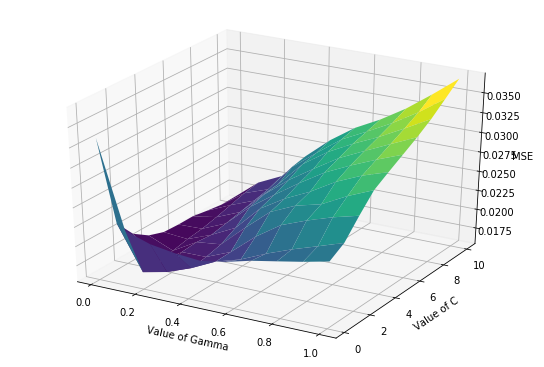

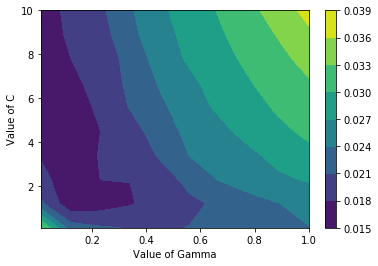

In [28]:
#finding the best hyperparameters for rbf kernel
min_error = 100
best_c = 0.1
best_gamma = 1
C_values = np.linspace(0.1, 10, 10)
gamma_values = np.linspace(0.01, 1, 10)
ac_mat = np.zeros([len(C_values), len(gamma_values)])
Xx, Yy = np.meshgrid(gamma_values, C_values)
for i in range(len(C_values)):
    for j in range(len(gamma_values)):        
        mse = cross_val_cvx(X, y, 5, C_values[i], 0.1, 'rbf', gamma_values[j], 1)
        if mse < min_error:
            min_error = mse
            best_c = C_values[i]
            best_gamma = gamma_values[j]
        ac_mat[i, j] = mse
print('cvxopt mse : ', min_error, 'best_c : ', best_c, 'best_gamma : ', best_gamma)
mse_sk = cross_val_sk(X, y, 5, best_c, 1, 'rbf', best_gamma, 1)
print('sklearn mse : ', mse_sk)
# print(np.sort(ans.support_))
# print(ans.support_.shape)

plt.figure(figsize=(9.5,6.5))
ax = plt.axes(projection='3d')
ax.plot_surface(Xx, Yy, ac_mat, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Value of Gamma')
ax.set_ylabel('Value of C')
ax.set_zlabel('MSE');
plt.show()
plt.contourf(Xx, Yy, ac_mat)
plt.colorbar()
plt.xlabel('Value of Gamma')
plt.ylabel('Value of C')
plt.show()


# Polynomial kernel


(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.3618e+01 -1.0180e+03  1e+03  9e-14  1e-12
 1:  2.9525e+01 -4.9435e+01  8e+01  2e-13  1e-12
 2:  4.9810e+00 -8.0444e+00  1e+01  1e-13  1e-12
 3: -4.8270e-01 -4.5883e+00  4e+00  1e-14  7e-13
 4: -2.0087e+00 -3.4437e+00  1e+00  4e-14  4e-13
 5: -2.5563e+00 -3.0402e+00  5e-01  1e-14  3e-13
 6: -2.7413e+00 -2.8711e+00  1e-01  1e-14  2e-13
 7: -2.7921e+00 -2.8222e+00  3e-02  2e-14  2e-13
 8: -2.8064e+00 -2.8081e+00  2e-03  1e-14  3e-13
 9: -2.8072e+00 -2.8072e+00  4e-05  4e-15  3e-13
10: -2.8072e+00 -2.8072e+00  4e-07  2e-16  3e-13
Optimal solution found.
(101,)
0.004855026816774021
0.004636352422692149


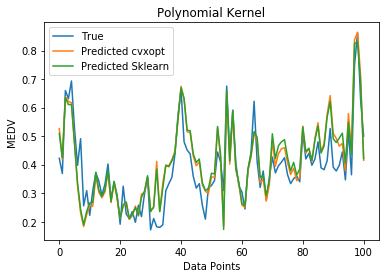

In [14]:
#plot of the predicted MEDV values vs the true values for the polynomial kernel with degree = 2
X_train = X[101: , :]
y_train = y[101: ]
X_test = X[:101, :]
y_test = y[:101]
reg = svm.SVR(kernel = 'poly', gamma = 1, degree = 2, C = 1, epsilon = 0.1).fit(X_train, y_train.ravel()) 
y_sk = reg.predict(X_test)
# score1 = reg.score(X_test, y_test)
y_pred = svr_cvxopt(X_train, y_train, X_test, 1, 0.1, 'poly', 1, 2)
# print(y_pred)
# print(y_sk)
# print(y)
y_pred = y_pred[:, 0]
print(y_pred.shape)
print((np.linalg.norm(y_pred - y_test) ** 2)/y_test.shape[0])
print((np.linalg.norm(y_sk - y_test) ** 2)/y_test.shape[0])
# print(np.max(y_sk-y_test))

Xx = np.array(list(range(0, y_test.shape[0]))).reshape(y_test.shape[0], 1)
plt.plot(Xx, y_test, label ='True')
plt.plot(Xx, y_pred, label ='Predicted cvxopt')

plt.plot(Xx, y_sk, label ='Predicted Sklearn')
plt.xlabel('Data Points')
plt.ylabel('MEDV')
plt.legend()
plt.title('Polynomial Kernel')
plt.show()

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  4.0066e+01 -8.7532e+03  9e+03  9e-13  1e-08
 1:  3.8049e+01 -5.2622e+02  6e+02  2e-13  1e-08
 2:  2.4247e+01 -7.6287e+01  1e+02  1e-12  1e-08
 3:  4.0673e+00 -2.5881e+01  3e+01  3e-13  9e-09
 4: -6.8425e+00 -1.4814e+01  8e+00  5e-13  6e-09
 5: -9.3624e+00 -1.1298e+01  2e+00  4e-13  5e-09
 6: -9.9283e+00 -1.0222e+01  3e-01  2e-16  5e-09
 7: -9.9997e+00 -1.0042e+01  4e-02  3e-14  4e-09
 8: -1.0010e+01 -1.0015e+01  5e-03  3e-14  4e-09
 9: -1.0011e+01 -1.0012e+01  7e-04  6e-14  4e-09
10: -1.0011e+01 -1.0011e+01  3e-05  2e-16  4e-09
11: -1.0011e+01 -1.0011e+01  4e-07  1e-13  4e-09
Optimal solution found.
(101,)


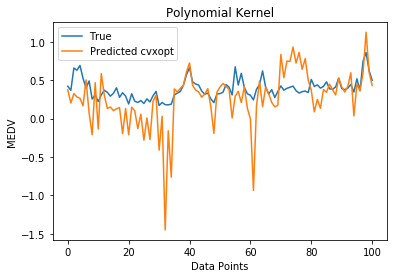

In [27]:
#plot of the predicted MEDV values vs the true values for the polynomial kernel with degree = 2
X_train = X[101: , :]
y_train = y[101: ]
X_test = X[:101, :]
y_test = y[:101]
reg = svm.SVR(kernel = 'poly', gamma = 1, degree = 5, C = 1, epsilon = 0.1).fit(X_train, y_train.ravel()) 
# y_sk = reg.predict(X_test)
# score1 = reg.score(X_test, y_test)
y_pred = svr_cvxopt(X_train, y_train, X_test, 10, 0.01, 'poly', 1, 6)
# print(y_pred)
# print(y_sk)
# print(y)
y_pred = y_pred[:, 0]
print(y_pred.shape)
# print((np.linalg.norm(y_pred - y_test) ** 2)/y_test.shape[0])
# print((np.linalg.norm(y_sk - y_test) ** 2)/y_test.shape[0])
# # print(np.max(y_sk-y_test))

Xx = np.array(list(range(0, y_test.shape[0]))).reshape(y_test.shape[0], 1)
plt.plot(Xx, y_test, label ='True')
plt.plot(Xx, y_pred, label ='Predicted cvxopt')

# plt.plot(Xx, y_sk, label ='Predicted Sklearn')
plt.xlabel('Data Points')
plt.ylabel('MEDV')
plt.legend()
plt.title('Polynomial Kernel')
plt.show()

(506, 1)
     pcost       dcost       gap    pres   dres
 0:  4.5047e+01 -1.0935e+03  1e+03  6e-14  1e-09
 1:  4.0719e+01 -4.3690e+01  8e+01  2e-13  1e-09
 2:  8.0523e+00 -4.9279e+00  1e+01  2e-13  8e-10
 3:  3.1068e+00 -2.0035e+00  5e+00  1e-14  3e-10
 4:  3.7791e-01 -3.8254e-01  8e-01  4e-15  9e-11
 5:  5.0581e-02 -7.1227e-02  1e-01  1e-15  2e-11
 6:  7.6680e-03 -2.5316e-02  3e-02  6e-16  7e-12
 7: -3.9541e-03 -1.2309e-02  8e-03  2e-16  4e-12
 8: -6.8692e-03 -8.8890e-03  2e-03  2e-16  3e-12
 9: -7.6153e-03 -8.0244e-03  4e-04  2e-16  3e-12
10: -7.7732e-03 -7.8406e-03  7e-05  2e-16  3e-12
11: -7.8026e-03 -7.8063e-03  4e-06  2e-16  3e-12
12: -7.8042e-03 -7.8043e-03  1e-07  2e-16  3e-12
13: -7.8043e-03 -7.8043e-03  2e-09  2e-16  3e-12
Optimal solution found.


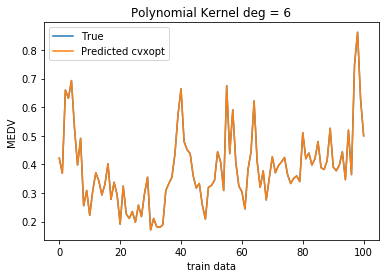

In [29]:
#plot of the predicted MEDV values vs the true values for the polynomial kernel with degree = 2
X_train = X
y_train = y
X_test = X[:101, :]
y_test = y[:101]
# X_train = X[:101, :]
# y_train = y[:101]
# reg = svm.SVR(kernel = 'poly', gamma = 1, degree = 5, C = 1, epsilon = 0.1).fit(X_train, y_train.ravel()) 
# y_sk = reg.predict(X_train)
# score1 = reg.score(X_test, y_test)
y_pred = svr_cvxopt(X_train, y_train, X_test, 1, 0.1, 'poly', 1, 6)
# print(y_pred)
# print(y_sk)
# print(y)
y_pred = y_pred[:, 0]
# print(y_pred.shape)
# print((np.linalg.norm(y_pred - y_train) ** 2)/y_train.shape[0])
# print((np.linalg.norm(y_sk - y_train) ** 2)/y_train.shape[0])
# print(np.max(y_sk-y_test))

Xx = np.array(list(range(0, y_test.shape[0]))).reshape(y_test.shape[0], 1)
plt.plot(Xx, y_test, label ='True')
plt.plot(Xx, y_test, label ='Predicted cvxopt')

# plt.plot(Xx, y_sk, label ='Predicted Sklearn')
plt.xlabel('train data')
plt.ylabel('MEDV')
plt.legend()
plt.title('Polynomial Kernel deg = 6')
plt.show()

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.3618e+01 -1.0180e+03  1e+03  9e-14  1e-12
 1:  2.9525e+01 -4.9435e+01  8e+01  2e-13  1e-12
 2:  4.9810e+00 -8.0444e+00  1e+01  1e-13  1e-12
 3: -4.8270e-01 -4.5883e+00  4e+00  1e-14  7e-13
 4: -2.0087e+00 -3.4437e+00  1e+00  4e-14  4e-13
 5: -2.5563e+00 -3.0402e+00  5e-01  1e-14  3e-13
 6: -2.7413e+00 -2.8711e+00  1e-01  1e-14  2e-13
 7: -2.7921e+00 -2.8222e+00  3e-02  2e-14  2e-13
 8: -2.8064e+00 -2.8081e+00  2e-03  1e-14  3e-13
 9: -2.8072e+00 -2.8072e+00  4e-05  4e-15  3e-13
10: -2.8072e+00 -2.8072e+00  4e-07  2e-16  3e-13
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  8.8273e+00 -2.1978e+02  2e+02  3e-14  1e-13
 1:  7.8949e+00 -9.1965e+00  2e+01  2e-14  2e-13
 2:  1.4652e+00 -1.0921e+00  3e+00  8e-16  1e-13
 3:  1.4862e-02 -3.0431e-01  3e-01  4e-15  3e-14
 4: -9.8351e-02 -1.9542e-01  1e-01  2e-15  1e-14
 5: -1.3685e-01 -1.5816e-01  2e-02  1e-15  1e-14
 6: -1.4458e-01 -1.5338e-01  

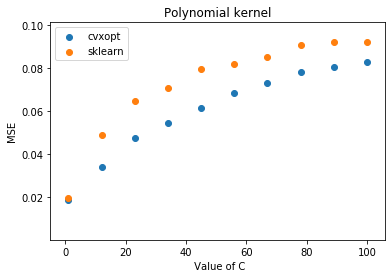

In [15]:
#plot of the MSE vs the hyperparamter C for polynomial kernel with degree = 2
x_values = np.linspace(1, 100, 10, endpoint=True)
mse_cvxopt = []
mse_sk = []
# mse_sklearn = []
for i in x_values:         
    mse1, mse2 = cross_val(X, y, 5, i, 0.1, 'poly', 1, 2)
    mse_cvxopt.append(mse1)
    mse_sk.append(mse2)

print(mse_cvxopt)
print(mse_sk)   
plt.scatter(x_values, mse_cvxopt, label ='cvxopt')
plt.scatter(x_values, mse_sk, label ='sklearn')

plt.xlabel(' Value of C')
plt.ylabel('MSE')
plt.legend()
plt.title('Polynomial kernel')
plt.show()
# plt.savefig('MEDV vs data.png')

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.3618e+01 -1.0180e+03  1e+03  9e-14  1e-12
 1:  2.9525e+01 -4.9435e+01  8e+01  2e-13  1e-12
 2:  4.9810e+00 -8.0444e+00  1e+01  1e-13  1e-12
 3: -4.8270e-01 -4.5883e+00  4e+00  1e-14  7e-13
 4: -2.0087e+00 -3.4437e+00  1e+00  4e-14  4e-13
 5: -2.5563e+00 -3.0402e+00  5e-01  1e-14  3e-13
 6: -2.7413e+00 -2.8711e+00  1e-01  1e-14  2e-13
 7: -2.7921e+00 -2.8222e+00  3e-02  2e-14  2e-13
 8: -2.8064e+00 -2.8081e+00  2e-03  1e-14  3e-13
 9: -2.8072e+00 -2.8072e+00  4e-05  4e-15  3e-13
10: -2.8072e+00 -2.8072e+00  4e-07  2e-16  3e-13
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  8.8273e+00 -2.1978e+02  2e+02  3e-14  1e-13
 1:  7.8949e+00 -9.1965e+00  2e+01  2e-14  2e-13
 2:  1.4652e+00 -1.0921e+00  3e+00  8e-16  1e-13
 3:  1.4862e-02 -3.0431e-01  3e-01  4e-15  3e-14
 4: -9.8351e-02 -1.9542e-01  1e-01  2e-15  1e-14
 5: -1.3685e-01 -1.5816e-01  2e-02  1e-15  1e-14
 6: -1.4458e-01 -1.5338e-01  

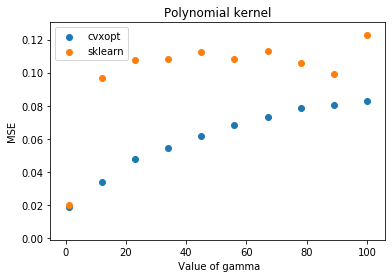

In [16]:
#plot of the MSE vs the hyperparamter gamma for polynomial kernel with degree = 2
x_values = np.linspace(1, 100, 10, endpoint=True)
mse_cvxopt = []
mse_sk = []
# mse_sklearn = []
for i in x_values:         
    mse1, mse2 = cross_val(X, y, 5, 1, 0.1, 'poly', i, 2)
    mse_cvxopt.append(mse1)
    mse_sk.append(mse2)

print(mse_cvxopt)
print(mse_sk)   
plt.scatter(x_values, mse_cvxopt, label ='cvxopt')
plt.scatter(x_values, mse_sk, label ='sklearn')

plt.xlabel(' Value of gamma')
plt.ylabel('MSE')
plt.legend()
plt.title('Polynomial kernel')
plt.show()
# plt.savefig('MEDV vs data.png')

(405, 1)
     pcost       dcost       gap    pres   dres
 0: -4.6591e+00 -1.0404e+02  3e+03  2e+01  3e-15
 1:  2.8627e+00 -9.5834e+01  1e+02  2e-15  1e-14
 2:  2.3059e+00 -8.6651e+00  1e+01  5e-15  2e-14
 3: -5.6303e-03 -1.9214e+00  2e+00  2e-15  1e-14
 4: -8.3618e-01 -1.3626e+00  5e-01  4e-16  7e-15
 5: -1.0096e+00 -1.2128e+00  2e-01  4e-15  5e-15
 6: -1.0790e+00 -1.1515e+00  7e-02  2e-15  5e-15
 7: -1.1096e+00 -1.1233e+00  1e-02  3e-15  5e-15
 8: -1.1159e+00 -1.1172e+00  1e-03  2e-16  5e-15
 9: -1.1165e+00 -1.1166e+00  3e-05  9e-16  5e-15
10: -1.1166e+00 -1.1166e+00  4e-07  4e-16  5e-15
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0: -5.9294e-01 -2.3368e+01  6e+02  2e+01  4e-16
 1:  7.5243e-01 -2.1324e+01  2e+01  2e-15  2e-15
 2:  6.2929e-01 -1.3600e+00  2e+00  8e-16  2e-15
 3:  3.3693e-02 -3.1345e-01  3e-01  2e-15  1e-15
 4: -7.9524e-02 -2.1798e-01  1e-01  2e-16  6e-16
 5: -1.0694e-01 -1.9135e-01  8e-02  9e-16  5e-16
 6: -1.2855e-01 -1.6822e-01  

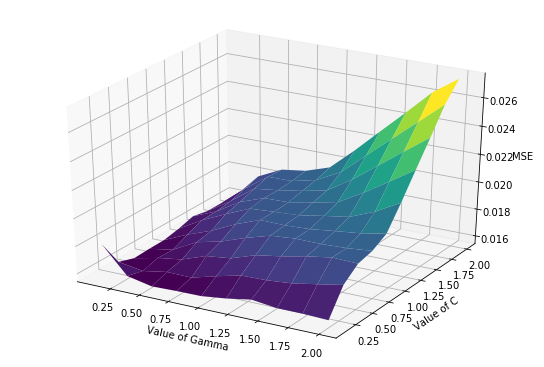

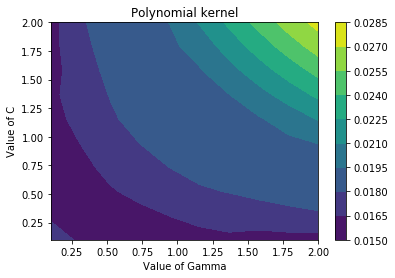

In [11]:
#finding the best hyperparameters for the polynomial kernel with degree = 2
min_error = 100
best_c = 0.1
best_gamma = 1
C_values = np.linspace(0.1, 2, 10)
gamma_values = np.linspace(0.1, 2, 10)
ac_mat = np.zeros([len(C_values), len(gamma_values)])
Xx, Yy = np.meshgrid(gamma_values, C_values)
for i in range(len(C_values)):
    for j in range(len(gamma_values)):        
        mse = cross_val_cvx(X, y, 5, C_values[i], 0.1, 'poly', gamma_values[j], 2)
        if mse < min_error:
            min_error = mse
            best_c = C_values[i]
            best_gamma = gamma_values[j]
        ac_mat[i, j] = mse
print('cvxopt mse : ', min_error, 'best_c : ', best_c, 'best_gamma : ', best_gamma)
mse_sk = cross_val_sk(X, y, 5, best_c, 1, 'poly', best_gamma, 2)
print('sklearn mse : ', mse_sk)
# print(np.sort(ans.support_))
# print(ans.support_.shape)

plt.figure(figsize=(9.5,6.5))
ax = plt.axes(projection='3d')
ax.plot_surface(Xx, Yy, ac_mat, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Value of Gamma')
ax.set_ylabel('Value of C')
ax.set_zlabel('MSE');
plt.show()
plt.contourf(Xx, Yy, ac_mat)
plt.colorbar()
plt.xlabel('Value of Gamma')
plt.ylabel('Value of C')
plt.title('Polynomial kernel')
plt.show()


(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.1069e+01 -1.0438e+03  1e+03  3e-14  3e-13
 1:  2.5688e+01 -5.6501e+01  8e+01  1e-16  4e-13
 2: -1.7302e-01 -1.4048e+01  1e+01  5e-14  3e-13
 3: -5.3463e+00 -1.0498e+01  5e+00  7e-14  2e-13
 4: -7.5203e+00 -8.8308e+00  1e+00  3e-14  1e-13
 5: -8.0178e+00 -8.4297e+00  4e-01  4e-14  1e-13
 6: -8.1442e+00 -8.3217e+00  2e-01  4e-15  1e-13
 7: -8.2098e+00 -8.2669e+00  6e-02  7e-15  1e-13
 8: -8.2327e+00 -8.2454e+00  1e-02  7e-15  1e-13
 9: -8.2383e+00 -8.2404e+00  2e-03  2e-14  1e-13
10: -8.2393e+00 -8.2393e+00  2e-05  4e-14  1e-13
11: -8.2393e+00 -8.2393e+00  2e-07  2e-14  1e-13
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  8.5706e+00 -2.2923e+02  2e+02  2e-15  4e-14
 1:  7.5788e+00 -1.0458e+01  2e+01  2e-15  5e-14
 2:  1.4652e+00 -1.6440e+00  3e+00  8e-16  3e-14
 3:  1.9632e-01 -8.4591e-01  1e+00  5e-15  1e-14
 4: -1.4027e-01 -5.4329e-01  4e-01  2e-15  8e-15
 5: -2.6542e-01 -4.4041e-01  

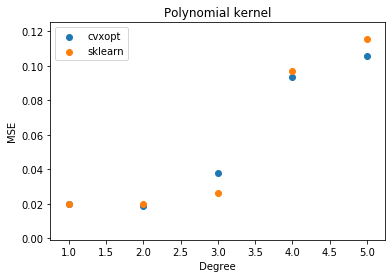

In [12]:
#plot of the MSE vs the degree for polynomial kernel
x_values = np.linspace(1, 5, 5, endpoint=True)
mse_cvxopt = []
mse_sk = []
# mse_sklearn = []
for i in x_values:         
    mse1, mse2 = cross_val(X, y, 5, 1, 0.1, 'poly', 1, i)
    mse_cvxopt.append(mse1)
    mse_sk.append(mse2)

print(mse_cvxopt)
print(mse_sk)   
plt.scatter(x_values, mse_cvxopt, label ='cvxopt')
plt.scatter(x_values, mse_sk, label ='sklearn')

plt.xlabel(' Degree ')
plt.ylabel('MSE')
plt.legend()
plt.title('Polynomial kernel')
plt.show()
# plt.savefig('MEDV vs data.png')


# RH-SVR

In [12]:
#formulation of the rh-SVR
def svr_cvxopt_rh(X_train, y_train, X_test, C, eps, kernel_type, gamma, degree):
    X = X_train
    y = y_train
    m,n = X.shape
    y = y.reshape(-1,1) * 1
#     print(y.shape)
    q1 = 2*eps*y
    K = kernel(kernel_type, X, X, gamma, degree)
    K1 = K + y@y.T
    p1 = np.hstack((K1, K1*-1))
    a1 = np.hstack((np.ones(m), np.zeros(m)))
    a2 = np.hstack((np.zeros(m), np.ones(m)))
    P = cvxopt_matrix(np.vstack((p1, p1*-1)))
    q = cvxopt_matrix(np.vstack((q1, q1*-1)))
    G = cvxopt_matrix(np.vstack((np.eye(2*m)*-1, np.eye(2*m))))
    h = cvxopt_matrix(np.hstack((np.zeros(2*m), np.ones(2*m) * C)))
    A = cvxopt_matrix(np.vstack((a1, a2)))
    # print(A.shape)
    b = cvxopt_matrix(np.ones(2))

    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    variables = np.array(sol['x'])

    u = variables[:m]
    v = variables[m:2*m]
    delta = (u-v).T@y + 2*eps
    bias = (u-v).T@(K@(u+v))/(2*delta) + (u+v).T@y/2
    u1 = u/delta
    v1 = v/delta
    y_pred =  kernel(kernel_type, X, X_test, gamma, degree).T@(v1-u1) + bias
    #     print(y_pred)
    return y_pred


In [13]:
# k -fold cross validation, returns the MSE for the given parameters for RH-SVR 
def cross_val_rh(X, y, num_folds, C, eps, kernel_type, gamma, degree):
    y = y.reshape(-1,1) * 1
    m, n = X.shape
    batch_size = m//num_folds

    mse1 = 0
    for i in range(1, num_folds+1):
        X_test = X[(i-1)*batch_size: i*batch_size, :]
        y_test = y[(i-1)*batch_size: i*batch_size:, ]
        if i == 1:
            X_train = X[i*batch_size : , :]
            y_train = y[i*batch_size :, :]
        else:
            X_train = X[: (i-1)*batch_size, :]
            np.vstack((X_train, X[i*batch_size : , :]))
            y_train = y[: (i-1)*batch_size, :]
            np.vstack((y_train, y[i*batch_size : , :]))
        
        y_pred = svr_cvxopt_rh(X_train, y_train, X_test, C, eps, kernel_type, gamma, degree)
        y_pred = y_pred[:, 0]
        y_test = y_test[:, 0]

        mse1 += (np.linalg.norm(y_pred - y_test) ** 2)/y_test.shape[0]
        
    mse1 = mse1/num_folds

    return mse1
    

     pcost       dcost       gap    pres   dres
 0: -1.9294e-02 -8.1901e+02  3e+03  1e+00  2e-14
 1: -1.7095e-02 -2.1949e+02  2e+02  2e-02  2e-14
 2: -6.3468e-03 -5.1461e+00  5e+00  2e-04  1e-14
 3: -7.6911e-03 -4.1948e-01  4e-01  2e-05  2e-14
 4: -1.7243e-02 -2.1866e-01  2e-01  6e-16  9e-15
 5: -1.8708e-02 -8.3811e-02  7e-02  2e-16  8e-15
 6: -1.9704e-02 -4.7544e-02  3e-02  2e-16  9e-15
 7: -1.9990e-02 -2.2915e-02  3e-03  4e-16  8e-15
 8: -2.0000e-02 -2.0045e-02  5e-05  1e-15  8e-15
 9: -2.0000e-02 -2.0000e-02  5e-07  3e-16  9e-15
10: -2.0000e-02 -2.0000e-02  5e-09  4e-16  9e-15
Optimal solution found.
(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.1069e+01 -1.0438e+03  1e+03  4e-17  2e-13
 1:  2.5688e+01 -5.6501e+01  8e+01  1e-13  3e-13
 2: -1.7302e-01 -1.4048e+01  1e+01  9e-14  2e-13
 3: -5.3463e+00 -1.0498e+01  5e+00  6e-14  1e-13
 4: -7.5203e+00 -8.8308e+00  1e+00  7e-15  1e-13
 5: -8.0178e+00 -8.4297e+00  4e-01  1e-14  9e-14
 6: -8.1442e+00 -8.3217e+00  2e-01  4e

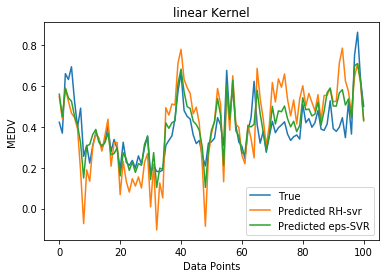

In [14]:
#plot of the predicted MEDV values by the RH-SVR vs the true values for the linear kernel
X_train = X[101: , :]
y_train = y[101: ]
X_test = X[:101, :]
y_test = y[:101]
# reg = svm.SVR(kernel = 'linear', degree = 2, C = 1, epsilon = 0.1).fit(X_train, y_train.ravel()) 
# y_sk = reg.predict(X_test)
# score1 = reg.score(X_test, y_test)
y_pred_rh = svr_cvxopt_rh(X_train, y_train, X_test, 1, 0.1, 'linear', 1, 2)
y_pred_eps = svr_cvxopt(X_train, y_train, X_test, 1, 0.1, 'linear', 1, 2)

y_pred_eps = y_pred_eps[:, 0]
y_pred_rh = y_pred_rh[:, 0]
print((np.linalg.norm(y_pred_eps - y_test) ** 2)/y_test.shape[0])
print((np.linalg.norm(y_pred_rh - y_test) ** 2)/y_test.shape[0])
# print(np.max(y_sk-y_test))

Xx = np.array(list(range(0, y_test.shape[0]))).reshape(y_test.shape[0], 1)
plt.plot(Xx, y_test, label ='True')
plt.plot(Xx, y_pred_rh, label ='Predicted RH-svr')

plt.plot(Xx, y_pred_eps, label ='Predicted eps-SVR')
plt.xlabel('Data Points')
plt.ylabel('MEDV')
plt.legend()
plt.title('linear Kernel')
plt.show()

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.1069e+01 -1.0438e+03  1e+03  4e-17  2e-13
 1:  2.5688e+01 -5.6501e+01  8e+01  1e-13  3e-13
 2: -1.7302e-01 -1.4048e+01  1e+01  9e-14  2e-13
 3: -5.3463e+00 -1.0498e+01  5e+00  6e-14  1e-13
 4: -7.5203e+00 -8.8308e+00  1e+00  7e-15  1e-13
 5: -8.0178e+00 -8.4297e+00  4e-01  1e-14  9e-14
 6: -8.1442e+00 -8.3217e+00  2e-01  4e-15  9e-14
 7: -8.2098e+00 -8.2669e+00  6e-02  1e-14  9e-14
 8: -8.2327e+00 -8.2454e+00  1e-02  4e-14  9e-14
 9: -8.2383e+00 -8.2404e+00  2e-03  4e-14  9e-14
10: -8.2393e+00 -8.2393e+00  2e-05  1e-14  1e-13
11: -8.2393e+00 -8.2393e+00  2e-07  1e-14  1e-13
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  8.5706e+00 -2.2923e+02  2e+02  6e-15  3e-14
 1:  7.5788e+00 -1.0458e+01  2e+01  4e-15  3e-14
 2:  1.4652e+00 -1.6440e+00  3e+00  7e-15  2e-14
 3:  1.9632e-01 -8.4591e-01  1e+00  2e-15  1e-14
 4: -1.4027e-01 -5.4329e-01  4e-01  6e-15  6e-15
 5: -2.6542e-01 -4.4041e-01  

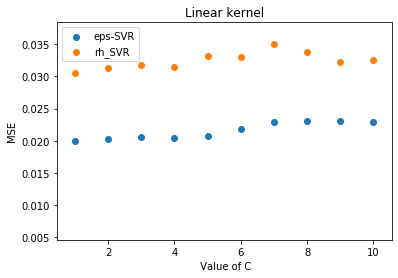

In [17]:
#plot of the MSE vs the hyperparamter C 
C_values = np.linspace(1, 10, 10, endpoint=True)
mse_cvxopt = []
mse_cvxopt_rh = []
mse_sk = []
# mse_sklearn = []
for i in C_values:         
    mse1 = cross_val_cvx(X, y, 5, i, 0.1, 'linear', 1, 1)
    mse2 = cross_val_rh(X, y, 5, i, 0.1, 'linear', 1, 1)
    mse3 = cross_val_sk(X, y, 5, i, 0.1, 'linear', 1, 1)
    mse_cvxopt.append(mse1)
    mse_cvxopt_rh.append(mse2)
    mse_sk.append(mse3)

print(mse_cvxopt)
print(mse_cvxopt_rh)
plt.scatter(C_values, mse_cvxopt, label ='eps-SVR')
plt.scatter(C_values, mse_cvxopt_rh, label ='rh_SVR')
# plt.scatter(C_values, mse_sk, label ='sklearn')

plt.xlabel(' Value of C')
plt.ylabel('MSE')
plt.legend()
plt.title('Linear kernel')
plt.show()
# plt.savefig('MEDV vs data.png')

(405, 1)
     pcost       dcost       gap    pres   dres
 0: -1.3713e+00 -1.0438e+03  1e+03  4e-14  2e-13
 1: -4.4494e+00 -8.4385e+01  8e+01  1e-14  3e-13
 2: -1.8921e+01 -3.5070e+01  2e+01  7e-14  3e-13
 3: -2.4805e+01 -2.9071e+01  4e+00  6e-14  3e-13
 4: -2.6122e+01 -2.7900e+01  2e+00  4e-14  3e-13
 5: -2.6692e+01 -2.7325e+01  6e-01  9e-14  2e-13
 6: -2.6928e+01 -2.7094e+01  2e-01  1e-13  3e-13
 7: -2.6989e+01 -2.7033e+01  4e-02  2e-13  3e-13
 8: -2.7005e+01 -2.7016e+01  1e-02  2e-13  2e-13
 9: -2.7010e+01 -2.7012e+01  2e-03  7e-14  3e-13
10: -2.7011e+01 -2.7011e+01  8e-05  1e-13  3e-13
11: -2.7011e+01 -2.7011e+01  1e-06  3e-14  3e-13
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  4.8053e-01 -2.2923e+02  2e+02  8e-15  3e-14
 1:  2.1459e-01 -1.5448e+01  2e+01  5e-14  4e-14
 2: -1.5138e+00 -4.5494e+00  3e+00  6e-14  4e-14
 3: -2.5190e+00 -3.3879e+00  9e-01  3e-14  3e-14
 4: -2.7897e+00 -3.1256e+00  3e-01  2e-14  3e-14
 5: -2.8885e+00 -3.0249e+00  

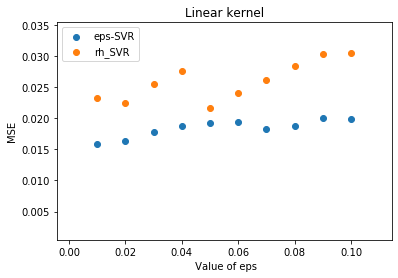

In [21]:
#plot of the MSE vs the hyperparamter C 
x_values = np.linspace(0.01, 0.1, 10, endpoint=True)
mse_cvxopt = []
mse_cvxopt_rh = []
mse_sk = []
# mse_sklearn = []
for i in x_values:         
    mse1 = cross_val_cvx(X, y, 5, 1, i, 'linear', 1, 1)
    mse2 = cross_val_rh(X, y, 5, 1, i, 'linear', 1, 1)
#     mse3 = cross_val_sk(X, y, 5, 1, 0.1, 'linear', 1, 1)
    mse_cvxopt.append(mse1)
    mse_cvxopt_rh.append(mse2)
    mse_sk.append(mse3)

print(mse_cvxopt)
print(mse_cvxopt_rh)
plt.scatter(x_values, mse_cvxopt, label ='eps-SVR')
plt.scatter(x_values, mse_cvxopt_rh, label ='rh_SVR')
# plt.scatter(C_values, mse_sk, label ='sklearn')

plt.xlabel(' Value of eps')
plt.ylabel('MSE')
plt.legend()
plt.title('Linear kernel')
plt.show()
# plt.savefig('MEDV vs data.png')

(405, 1)
     pcost       dcost       gap    pres   dres
 0:  3.1069e+01 -1.0438e+03  1e+03  4e-17  2e-13
 1:  2.5688e+01 -5.6501e+01  8e+01  1e-13  3e-13
 2: -1.7302e-01 -1.4048e+01  1e+01  9e-14  2e-13
 3: -5.3463e+00 -1.0498e+01  5e+00  6e-14  1e-13
 4: -7.5203e+00 -8.8308e+00  1e+00  7e-15  1e-13
 5: -8.0178e+00 -8.4297e+00  4e-01  1e-14  9e-14
 6: -8.1442e+00 -8.3217e+00  2e-01  4e-15  9e-14
 7: -8.2098e+00 -8.2669e+00  6e-02  1e-14  9e-14
 8: -8.2327e+00 -8.2454e+00  1e-02  4e-14  9e-14
 9: -8.2383e+00 -8.2404e+00  2e-03  4e-14  9e-14
10: -8.2393e+00 -8.2393e+00  2e-05  1e-14  1e-13
11: -8.2393e+00 -8.2393e+00  2e-07  1e-14  1e-13
Optimal solution found.
(101, 1)
     pcost       dcost       gap    pres   dres
 0:  8.5706e+00 -2.2923e+02  2e+02  6e-15  3e-14
 1:  7.5788e+00 -1.0458e+01  2e+01  4e-15  3e-14
 2:  1.4652e+00 -1.6440e+00  3e+00  7e-15  2e-14
 3:  1.9632e-01 -8.4591e-01  1e+00  2e-15  1e-14
 4: -1.4027e-01 -5.4329e-01  4e-01  6e-15  6e-15
 5: -2.6542e-01 -4.4041e-01  

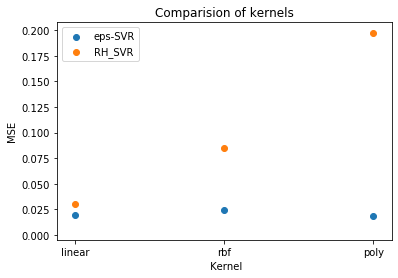

In [27]:
ktype = ['linear', 'rbf', 'poly']
mse_cvxopt = []
mse_cvxopt_rh = []
# mse_sklearn = []
for i in ktype:         
    mse1 = cross_val_cvx(X, y, 5, 1, 0.1, i, 1, 2)
    mse2 = cross_val_rh(X, y, 5, 1, 0.1, i, 1, 2)
    mse_cvxopt.append(mse1)
    mse_cvxopt_rh.append(mse2)

print(mse_cvxopt)
print(mse_cvxopt_rh)
plt.scatter(ktype, mse_cvxopt, label ='eps-SVR')
plt.scatter(ktype, mse_cvxopt_rh, label ='RH_SVR')

plt.xlabel(' Kernel')
plt.ylabel('MSE')
plt.legend()
plt.title('Comparision of kernels')
plt.show()
# plt.savefig('MEDV vs data.png')